In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas_datareader.data as pdr

import datetime as dt
import yfinance as yf

import random
import math
import shap


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Flatten, Conv2D, MaxPool2D, Input
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.wrappers.scikit_learn import KerasRegressor


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from tensorflow.keras import backend as K

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

# Bagging
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

# Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
plt.style.use('ggplot')

mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.alpha'] = 0.25

mpl.rcParams['legend.fontsize'] = 10

In [5]:
DATADIR = Path.cwd()

filepath = os.path.join(DATADIR, 'data_with_covid.csv')

D = pd.read_csv(filepath, index_col = [0], infer_datetime_format = True)
D.columns = (x.lower() for x in D.columns)

TRAIN_TEST_CUTOFF = int((len(D) * 0.8))

train_set = D.iloc[:TRAIN_TEST_CUTOFF, :]
test_set = D.iloc[TRAIN_TEST_CUTOFF:, :]

scaler = MinMaxScaler(feature_range = (-1, 1))
train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [6]:
def build_model(u, ep, v):
    X_train = []
    y_train = []

    for i in range(len(train_set_scaled)):
        X_train.append(train_set_scaled[i, 1:])
        y_train.append(train_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    print(X_train.shape, y_train.shape)

    def biLSTM(u):
        model = Sequential()
        model.add(Bidirectional(LSTM(units = u, return_sequences = True), input_shape = (X_train.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(units = u, return_sequences = True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(units = u, return_sequences = True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(units = u)))
        model.add(Dense(units = 1))
        return model
    
    model = biLSTM(u)

    model.compile(optimizer="adam", loss="mae", metrics=["mse"])

    model.summary()
    
    model.fit(X_train, y_train, epochs = ep, batch_size = 10, verbose=v)
    
    predict_train = model.predict(X_train, batch_size=10, verbose=v)
    
    X_test = []
    y_test = []

    for i in range(len(test_set_scaled)):
        X_test.append(test_set_scaled[i, 1:])
        y_test.append(test_set_scaled[i, 0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    y_test = np.reshape(y_test, (-1, 1))
    y_train=np.reshape(y_train,(-1,1))
    
    predicted_stock_price=model.predict(X_test)
    
    def print_error(trainY, testY, train_predict, test_predict):    
        ### Error of predictions
        train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
        test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
        ### Print RMSE
        print('Train RMSE: %.3f RMSE' % (train_rmse))
        print('Test RMSE: %.3f RMSE' % (test_rmse))
    
    print_error(y_train, y_test, predict_train, predicted_stock_price)
    
    pred_array = np.repeat(predicted_stock_price, len(D.columns), axis = -1)
    
    pred = scaler.inverse_transform(pred_array)[:,0]
    
    graph_test = pd.DataFrame(test_set.iloc[:,0])
    graph_test['pred'] = pred

    
    fig, ax = plt.subplots(figsize = (12,10))
    graph_test['gold'].plot(linestyle = '--')
    graph_test['pred'].plot(linestyle = '-')
    ax.set_title('Bi-LSTM')
    ax.legend()



(1800, 33, 1) (1800,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 33, 66)           9240      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 33, 66)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 33, 66)           26400     
 nal)                                                            
          

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Train RMSE: 0.031 RMSE
Test RMSE: 0.072 RMSE


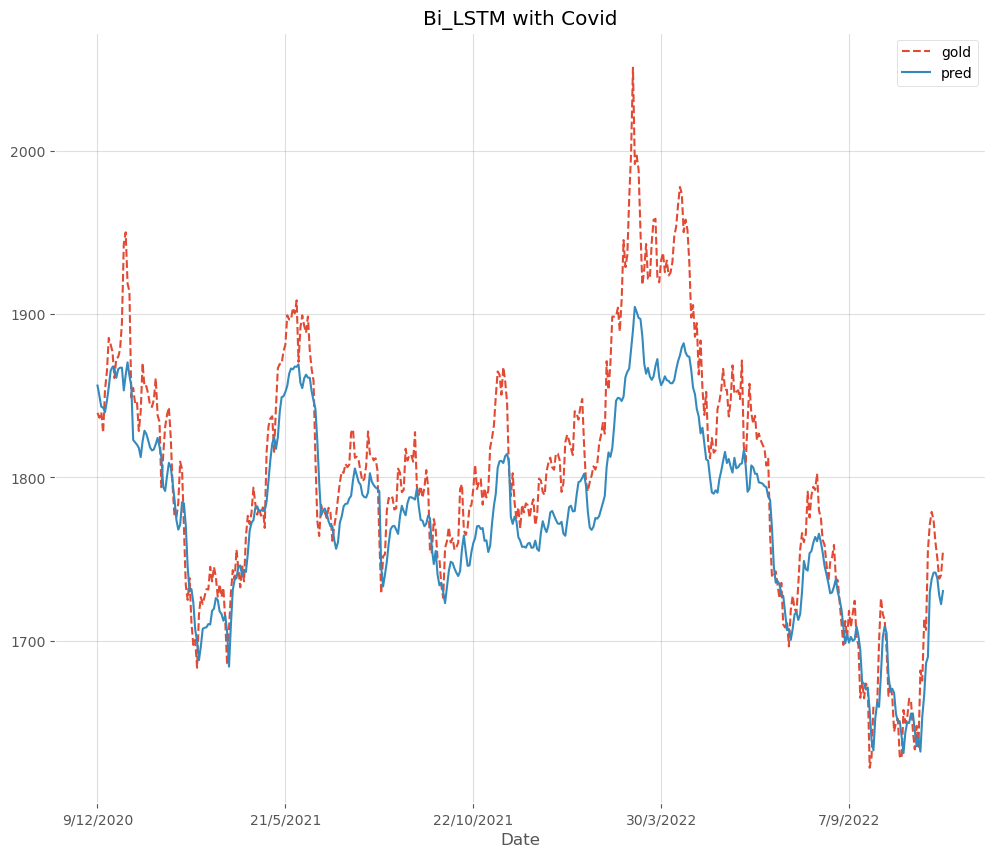

In [7]:
X_train = []
y_train = []

for i in range(len(train_set_scaled)):
    X_train.append(train_set_scaled[i, 1:])
    y_train.append(train_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape, y_train.shape)

def biLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 33, return_sequences = True), input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units = 33, return_sequences = True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units = 33, return_sequences = True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units = 33)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    return model

model = biLSTM()

model.compile(optimizer="adam", loss="mae", metrics=["mse"])

model.summary()

model.fit(X_train, y_train, epochs = 50, batch_size = 10, verbose=0)

predict_train = model.predict(X_train, batch_size=10, verbose=0)

X_test = []
y_test = []

for i in range(len(test_set_scaled)):
    X_test.append(test_set_scaled[i, 1:])
    y_test.append(test_set_scaled[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_test = np.reshape(y_test, (-1, 1))
y_train=np.reshape(y_train,(-1,1))

predicted_stock_price=model.predict(X_test)

def print_error(trainY, testY, train_predict, test_predict):    
    ### Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    ### Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))

print_error(y_train, y_test, predict_train, predicted_stock_price)

pred_array = np.repeat(predicted_stock_price, len(D.columns), axis = -1)

pred = scaler.inverse_transform(pred_array)[:,0]

graph_test = pd.DataFrame(test_set.iloc[:,0])
graph_test['pred'] = pred


fig, ax = plt.subplots(figsize = (12,10))
graph_test['gold'].plot(linestyle = '--')
graph_test['pred'].plot(linestyle = '-')
ax.set_title('Bi_LSTM with Covid')
ax.legend()


In [8]:
explainer = shap.DeepExplainer(model, X_test)
shap_values = explainer.shap_values(X_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [10]:
len(shap_values), len(shap_values[0]), len(shap_values[0][0])

(1, 451, 33)

In [11]:
Bi_LSTM_covid_shap = []
for i in range(len(shap_values[0])):
    Bi_LSTM_covid_shap.append(float(shap_values[0][i][-1]))
np.sum(Bi_LSTM_covid_shap)

1.1277466660519764e-07

In [14]:
T_data = test_set
T_data['prediction'] = pred
T_data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,gold,gold_lag_1,gold_lag_2,gold_lag_3,gold_lag_4,gold_lag_5,gold_lag_6,gold_lag_7,gold_lag_8,gold_lag_9,...,ppiaco,adpmnusnersa,payems,jtsjol,unrate,poilbreusdm,a191rl1q225sbea,ussthpi,sum_of_new_cases,prediction
Date,,,,,,,,,,,,,,,,,,,,,
9/12/2020,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,1787.79,1815.80,...,196.500,114447000,142279,6874,6.9,41.606818,-29.9,454.6,2798946,1856.240112
10/12/2020,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,1787.79,...,196.500,114447000,142279,6874,6.9,41.606818,-29.9,454.6,2835700,1850.028320
11/12/2020,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,...,196.500,114447000,142279,6874,6.9,41.606818,-29.9,454.6,2976177,1843.343262
14/12/2020,1827.35,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,...,196.500,114447000,142279,6874,6.9,41.606818,-29.9,454.6,2296344,1842.740112
15/12/2020,1853.64,1827.35,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,...,196.500,114447000,142279,6874,6.9,41.606818,-29.9,454.6,2725321,1839.963257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17/11/2022,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,1675.63,1681.87,...,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,1983454,1741.794678
18/11/2022,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,1675.63,...,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,2820428,1738.412109
21/11/2022,1738.05,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,...,268.693,121763000,153047,10687,3.5,90.608182,-1.6,578.7,1539529,1728.066895


In [15]:
T_data['pos'] = np.where(T_data['prediction'] > T_data['gold_lag_1'], 1, np.nan)
T_data['pos'] = np.where(T_data['prediction'] < T_data['gold_lag_1'], -1, T_data['pos'])
T_data['pos'] = np.where(T_data['prediction'] == T_data['gold_lag_1'], 0, T_data['pos'])
T_data['pos'].isnull().sum()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0

In [16]:
T_data['buyorsell'] = T_data['pos'].diff()
T_data['buyorsell'] = T_data['buyorsell'].fillna(T_data['pos'])
T_data['buyorsell'].isnull().sum()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0

In [17]:
T_data['return'] = np.log(T_data['gold'] / T_data['gold_lag_1'])
T_data['strategy'] = T_data['pos'] * T_data['return']
T_data['cum_sum_strategy'] = T_data['strategy'].cumsum().apply(np.exp)
T_data['cum_max_strategy'] = T_data['cum_sum_strategy'].cummax()
T_data['cum_max_strategy']
T_data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,gold,gold_lag_1,gold_lag_2,gold_lag_3,gold_lag_4,gold_lag_5,gold_lag_6,gold_lag_7,gold_lag_8,gold_lag_9,...,a191rl1q225sbea,ussthpi,sum_of_new_cases,prediction,pos,buyorsell,return,strategy,cum_sum_strategy,cum_max_strategy
Date,,,,,,,,,,,,,,,,,,,,,
9/12/2020,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,1787.79,1815.80,...,-29.9,454.6,2798946,1856.240112,-1.0,-1.0,-0.016717,0.016717,1.016857,1.016857
10/12/2020,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,1787.79,...,-29.9,454.6,2835700,1850.028320,1.0,2.0,-0.001621,-0.001621,1.015210,1.016857
11/12/2020,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,1776.95,...,-29.9,454.6,2976177,1843.343262,1.0,0.0,0.001784,0.001784,1.017023,1.017023
14/12/2020,1827.35,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,1815.24,...,-29.9,454.6,2296344,1842.740112,1.0,0.0,-0.006817,-0.006817,1.010114,1.017023
15/12/2020,1853.64,1827.35,1839.85,1836.57,1839.55,1870.56,1862.73,1838.86,1841.08,1831.28,...,-29.9,454.6,2725321,1839.963257,1.0,0.0,0.014284,0.014284,1.024646,1.024646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17/11/2022,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,1675.63,1681.87,...,-1.6,578.7,1983454,1741.794678,-1.0,0.0,-0.007600,0.007600,1.487938,1.549312
18/11/2022,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,1675.63,...,-1.6,578.7,2820428,1738.412109,-1.0,0.0,-0.005559,0.005559,1.496233,1.549312
21/11/2022,1738.05,1750.68,1760.44,1773.87,1778.94,1771.40,1771.24,1755.45,1706.74,1712.42,...,-1.6,578.7,1539529,1728.066895,-1.0,0.0,-0.007240,0.007240,1.507106,1.549312


In [ ]:
TRAIN_TEST_CUTOFF = int((len(D) * 0.8))

train_set = D.iloc[:TRAIN_TEST_CUTOFF, :]
test_set = D.iloc[TRAIN_TEST_CUTOFF:, :]

scaler = MinMaxScaler(feature_range = (-1, 1))
train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)

X_train = []
y_train = []

for i in range(len(train_set_scaled)):
    X_train.append(train_set_scaled[i, 1:])
    y_train.append(train_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape, y_train.shape)

X_test = []
y_test = []

for i in range(len(test_set_scaled)):
    X_test.append(test_set_scaled[i, 1:])
    y_test.append(test_set_scaled[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))